# Classification of Mice by Protein Expression Levels

## Project Goal

**Objective:** Analyze protein expression levels in the cerebral cortex of mice.<br>
**Classification:** Categorize mice based on genotype, behavior, and treatment.<br>
**Protein Identification:** Identify specific proteins that differentiate between these categories.<br>
**Biological Understanding:** Investigate the biological mechanisms underlying learning and memory.<br>
**Context:** Focus on Down syndrome to understand its impact on learning and memory processes.

In [1]:
import warnings
warnings.filterwarnings('ignore')

# Importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
!pip install catboost
!pip install xgboost
!pip install lightgbm

# Display plots inline
%matplotlib inline

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [2]:
# Load the dataset
data = pd.read_csv("Data_Cortex_Nuclear.csv")

# Display the first few rows of the dataset
data.head()

,MouseID,DYRK1A_N,ITSN1_N,BDNF_N,NR1_N,NR2A_N,pAKT_N,pBRAF_N,pCAMKII_N,pCREB_N,...,pCFOS_N,SYP_N,H3AcK18_N,EGR1_N,H3MeK4_N,CaNA_N,Genotype,Treatment,Behavior,class
0,309_1,0.503644,0.747193,0.430175,2.816329,5.990152,0.218830,0.177565,2.373744,0.232224,...,0.108336,0.427099,0.114783,0.131790,0.128186,1.675652,Control,Memantine,C/S,c-CS-m
1,309_2,0.514617,0.689064,0.411770,2.789514,5.685038,0.211636,0.172817,2.292150,0.226972,...,0.104315,0.441581,0.111974,0.135103,0.131119,1.743610,Control,Memantine,C/S,c-CS-m
2,309_3,0.509183,0.730247,0.418309,2.687201,5.622059,0.209011,0.175722,2.283337,0.230247,...,0.106219,0.435777,0.111883,0.133362,0.127431,1.926427,Control,Memantine,C/S,c-CS-m
3,309_4,0.442107,0.617076,0.358626,2.466947,4.979503,0.222886,0.176463,2.152301,0.207004,...,0.111262,0.391691,0.130405,0.147444,0.146901,1.700563,Control,Memantine,C/S,c-CS-m
4,309_5,0.434940,0.617430,0.358802,2.365785,4.718679,0.213106,0.173627,2.134014,0.192158,...,0.110694,0.434154,0.118481,0.140314,0.148380,1.839730,Control,Memantine,C/S,c-CS-m


**DATA PREPROCESSING**

In [3]:
# Check for missing values
print(data.isnull().sum())

MouseID      0
DYRK1A_N     3
ITSN1_N      3
BDNF_N       3
NR1_N        3
            ..
CaNA_N       0
Genotype     0
Treatment    0
Behavior     0
class        0
Length: 82, dtype: int64


In [4]:
# Handle missing values by filling with mean of each column
numeric_columns = data.select_dtypes(include=[np.number]).columns
data[numeric_columns] = data[numeric_columns].apply(lambda x: x.fillna(x.mean()), axis=0)

In [5]:
# Normalize/Scale the data
scaler = StandardScaler()

# Separating features and target
# Dropping non-numeric and target columns
X = data.drop(columns=['MouseID', 'Genotype', 'Treatment', 'Behavior', 'class'])
y = data['class']

# Scaling the features
X_scaled = scaler.fit_transform(X)

# Display the scaled data
pd.DataFrame(X_scaled, columns=X.columns).head()

,DYRK1A_N,ITSN1_N,BDNF_N,NR1_N,NR2A_N,pAKT_N,pBRAF_N,pCAMKII_N,pCREB_N,pELK_N,...,SHH_N,BAD_N,BCL2_N,pS6_N,pCFOS_N,SYP_N,H3AcK18_N,EGR1_N,H3MeK4_N,CaNA_N
0,0.312711,0.517934,2.253669,1.497362,2.304365,-0.345019,-0.158601,-0.899902,0.604115,0.691475,...,-1.305403,-1.333224,0.0,-1.066276,-0.987371,-0.285744,-1.011615,-1.416624,-1.607891,1.065901
1,0.356798,0.286501,1.880279,1.420009,1.976769,-0.518126,-0.334523,-0.963018,0.442658,0.359831,...,-0.906725,-1.558938,0.0,-1.046167,-1.162114,-0.067645,-1.063458,-1.325218,-1.546844,1.280291
2,0.334966,0.450465,2.012928,1.124860,1.909149,-0.581298,-0.226891,-0.969835,0.543335,0.284600,...,-1.138611,-1.489897,0.0,-0.926271,-1.079366,-0.155059,-1.065130,-1.373257,-1.623595,1.857038
3,0.065474,-0.000103,0.802123,0.489481,1.219245,-0.247424,-0.199461,-1.071196,-0.171236,0.357061,...,-1.192887,-0.950252,0.0,-1.285019,-0.860192,-0.818989,-0.723367,-0.984718,-1.218364,1.144490
4,0.036682,0.001305,0.805692,0.197652,0.939202,-0.482759,-0.304516,-1.085341,-0.627671,0.162107,...,-0.727242,-1.057141,0.0,-1.172895,-0.884881,-0.179502,-0.943378,-1.181435,-1.187585,1.583530


**EXPLORATORY DATA ANALYSIS**

In [6]:
# Summary statistics
print(data.describe())

          DYRK1A_N      ITSN1_N       BDNF_N        NR1_N       NR2A_N   
count  1080.000000  1080.000000  1080.000000  1080.000000  1080.000000  \
mean      0.425810     0.617102     0.319088     2.297269     3.843934   
std       0.249015     0.251290     0.049314     0.346810     0.931802   
min       0.145327     0.245359     0.115181     1.330831     1.737540   
25%       0.288163     0.473669     0.287650     2.059152     3.160287   
50%       0.366540     0.566365     0.316703     2.297269     3.763306   
75%       0.487574     0.697500     0.348039     2.528035     4.425107   
max       2.516367     2.602662     0.497160     3.757641     8.482553   

            pAKT_N      pBRAF_N    pCAMKII_N      pCREB_N       pELK_N  ...   
count  1080.000000  1080.000000  1080.000000  1080.000000  1080.000000  ...  \
mean      0.233168     0.181846     3.537109     0.212574     1.428682  ...   
std       0.041577     0.027004     1.293368     0.032542     0.466254  ...   
min       0.06323

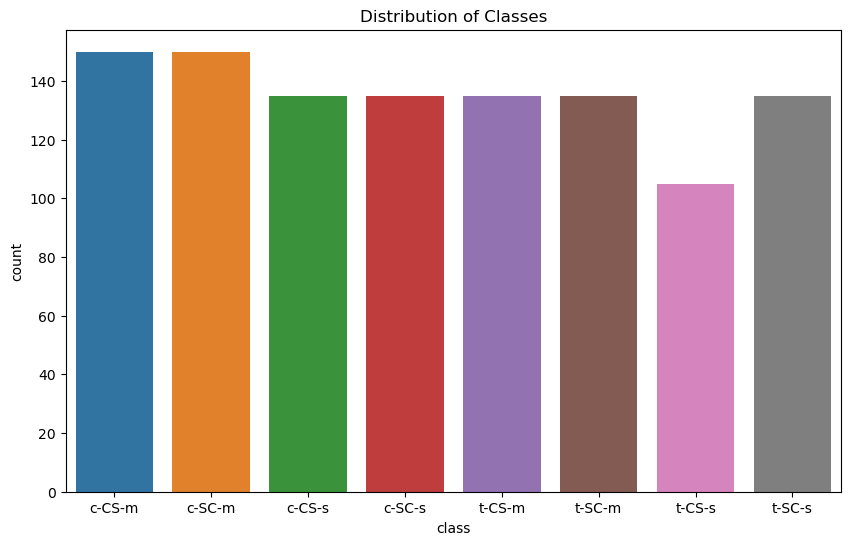

In [7]:
# Visualize distribution of classes
plt.figure(figsize=(10, 6))
sns.countplot(x='class', data=data)
plt.title('Distribution of Classes')
plt.show()

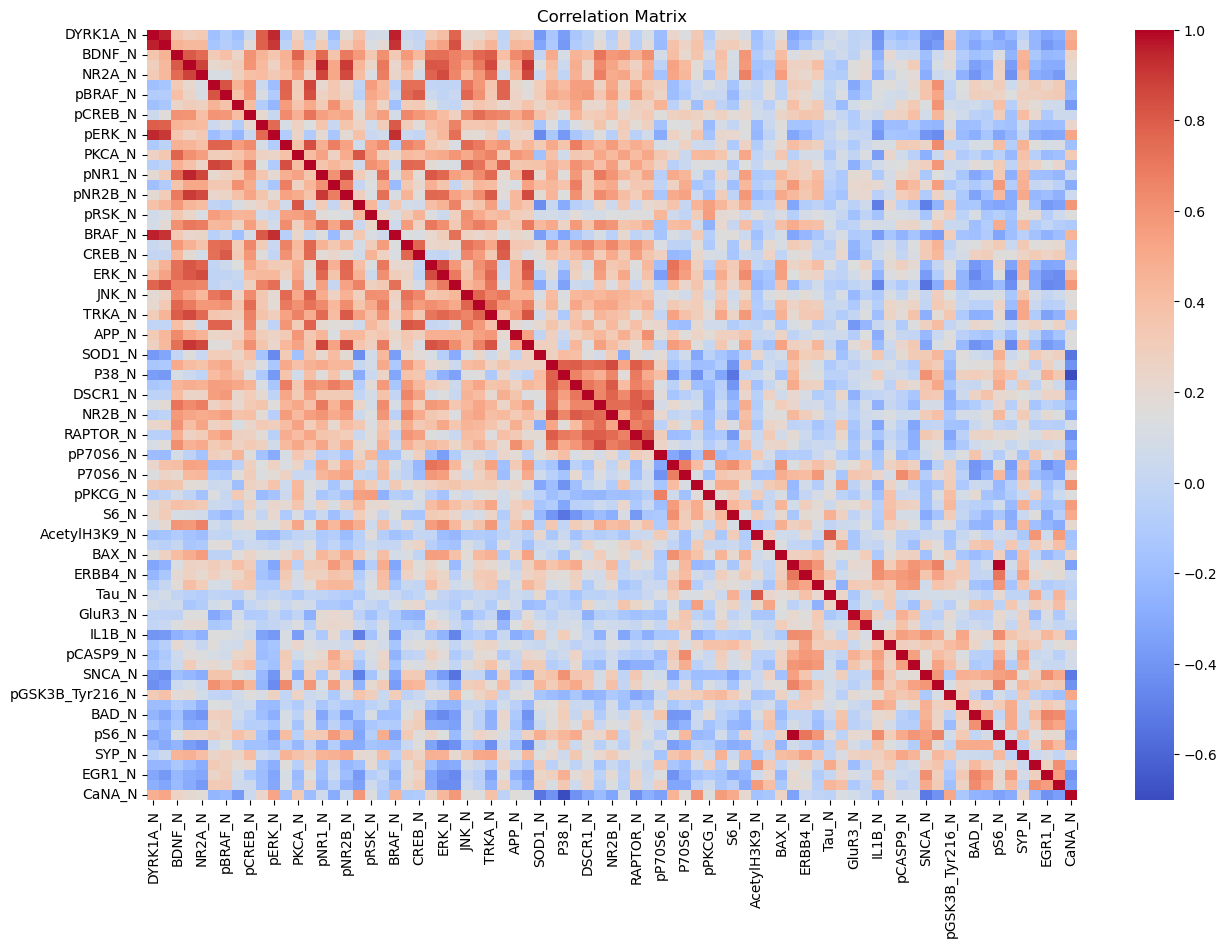

In [8]:
# Correlation matrix
numeric_data = data.select_dtypes(include=['float', 'int'])
corr_matrix = numeric_data.corr()
plt.figure(figsize=(15, 10))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

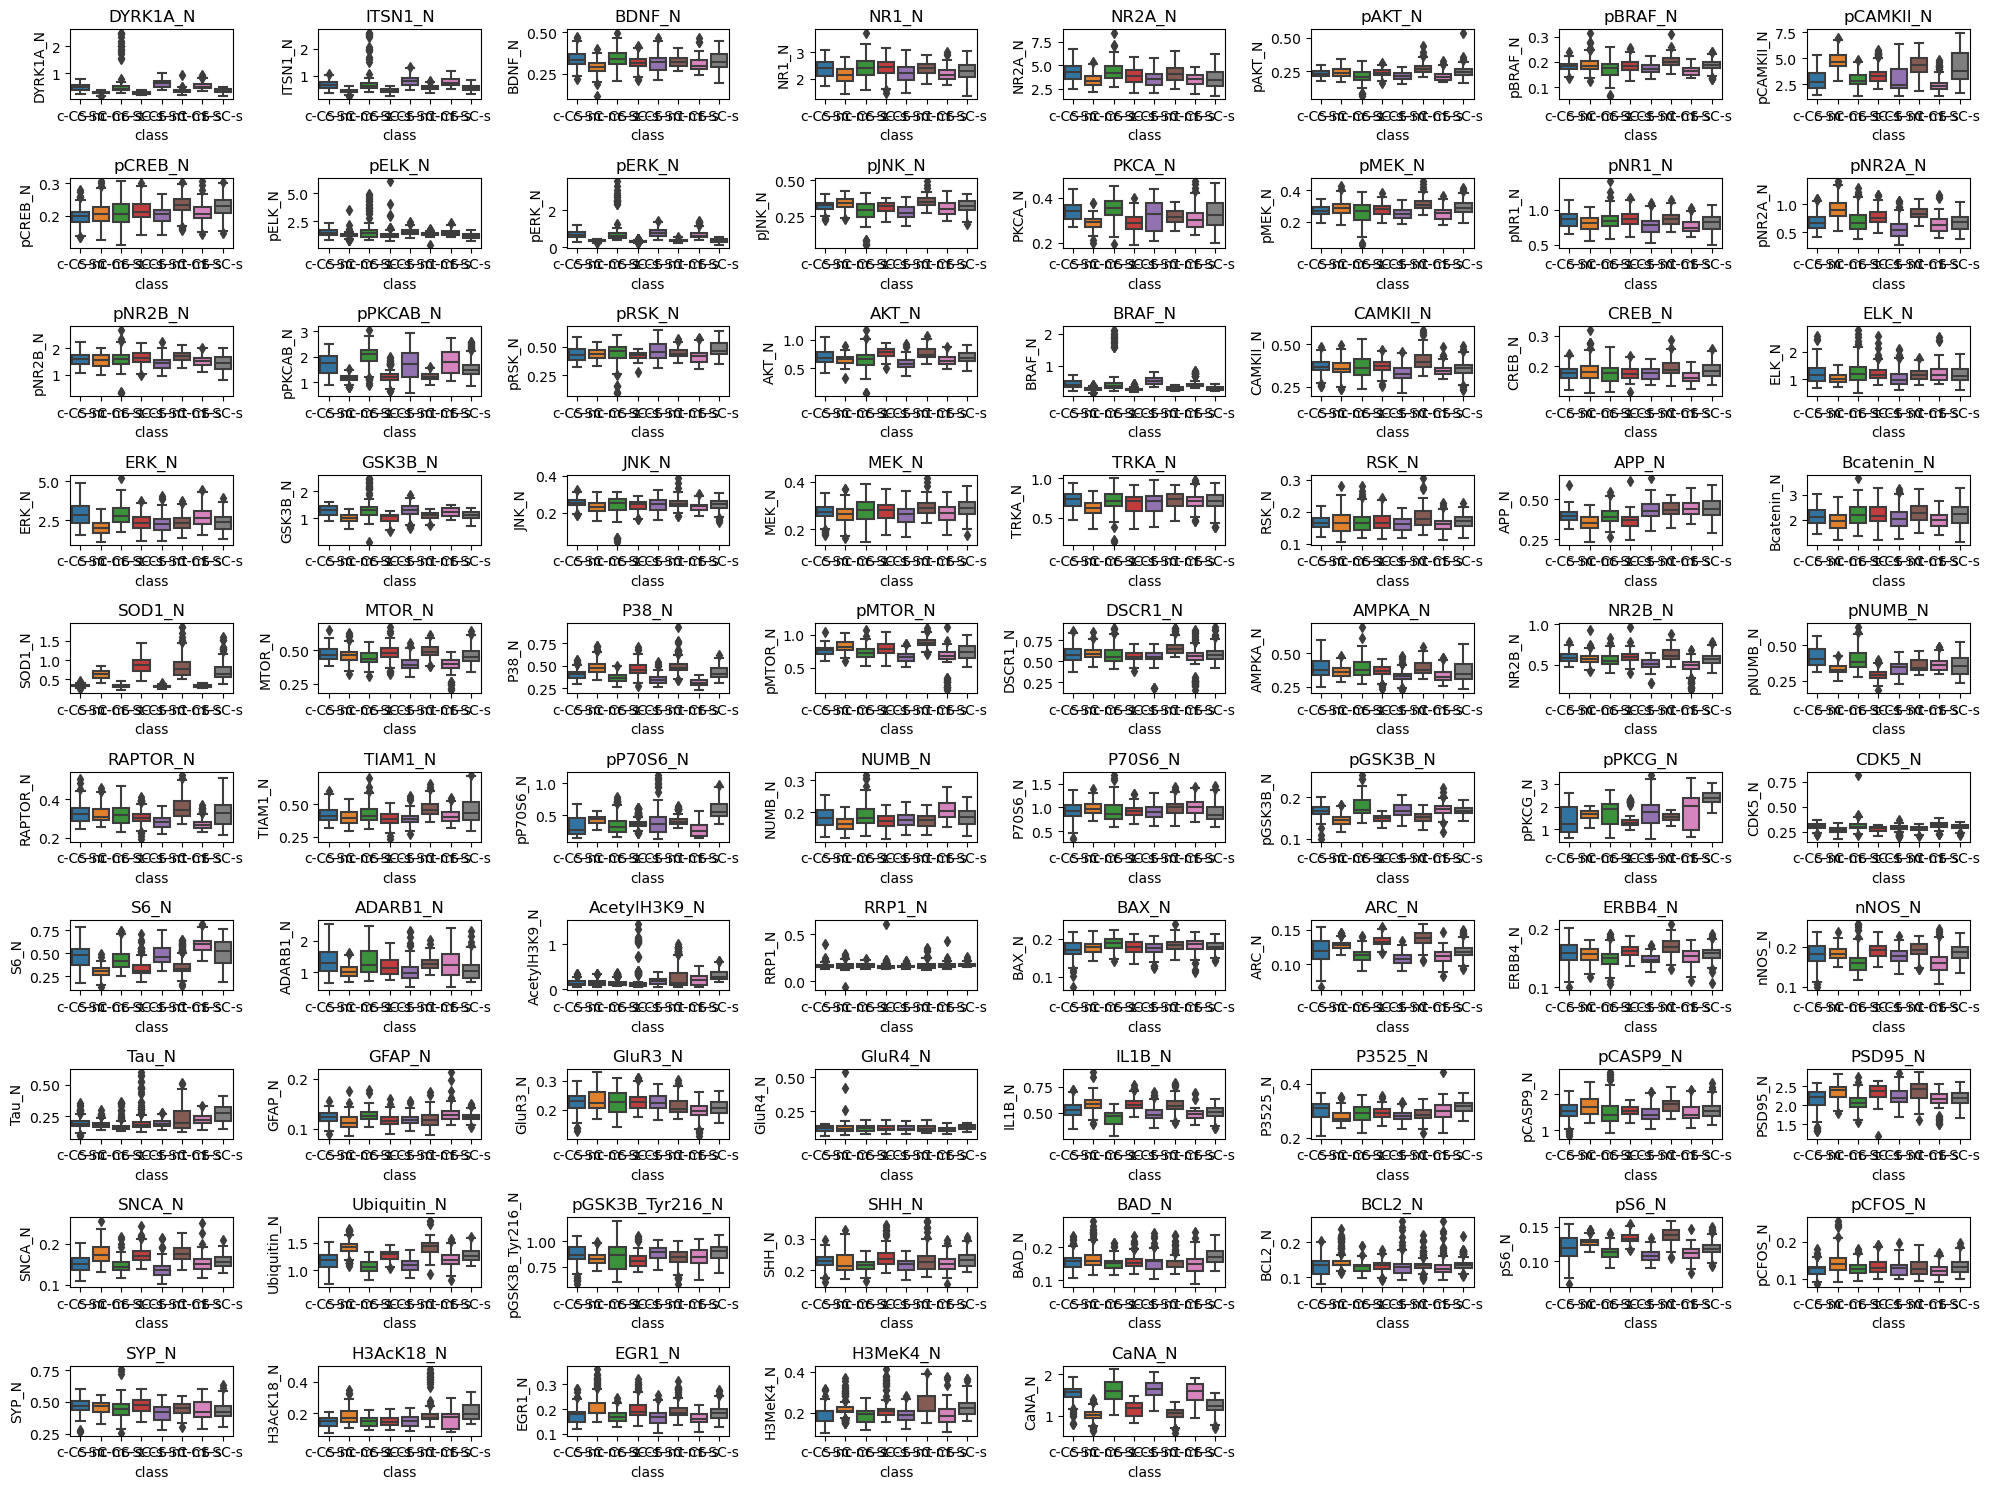

In [9]:
# Box plots for protein expression levels by class
plt.figure(figsize=(20, 15))
for i, column in enumerate(data.columns[1:78], 1):
    plt.subplot(10, 8, i)
    sns.boxplot(x='class', y=column, data=data)
    plt.title(column)
plt.tight_layout()
plt.show()

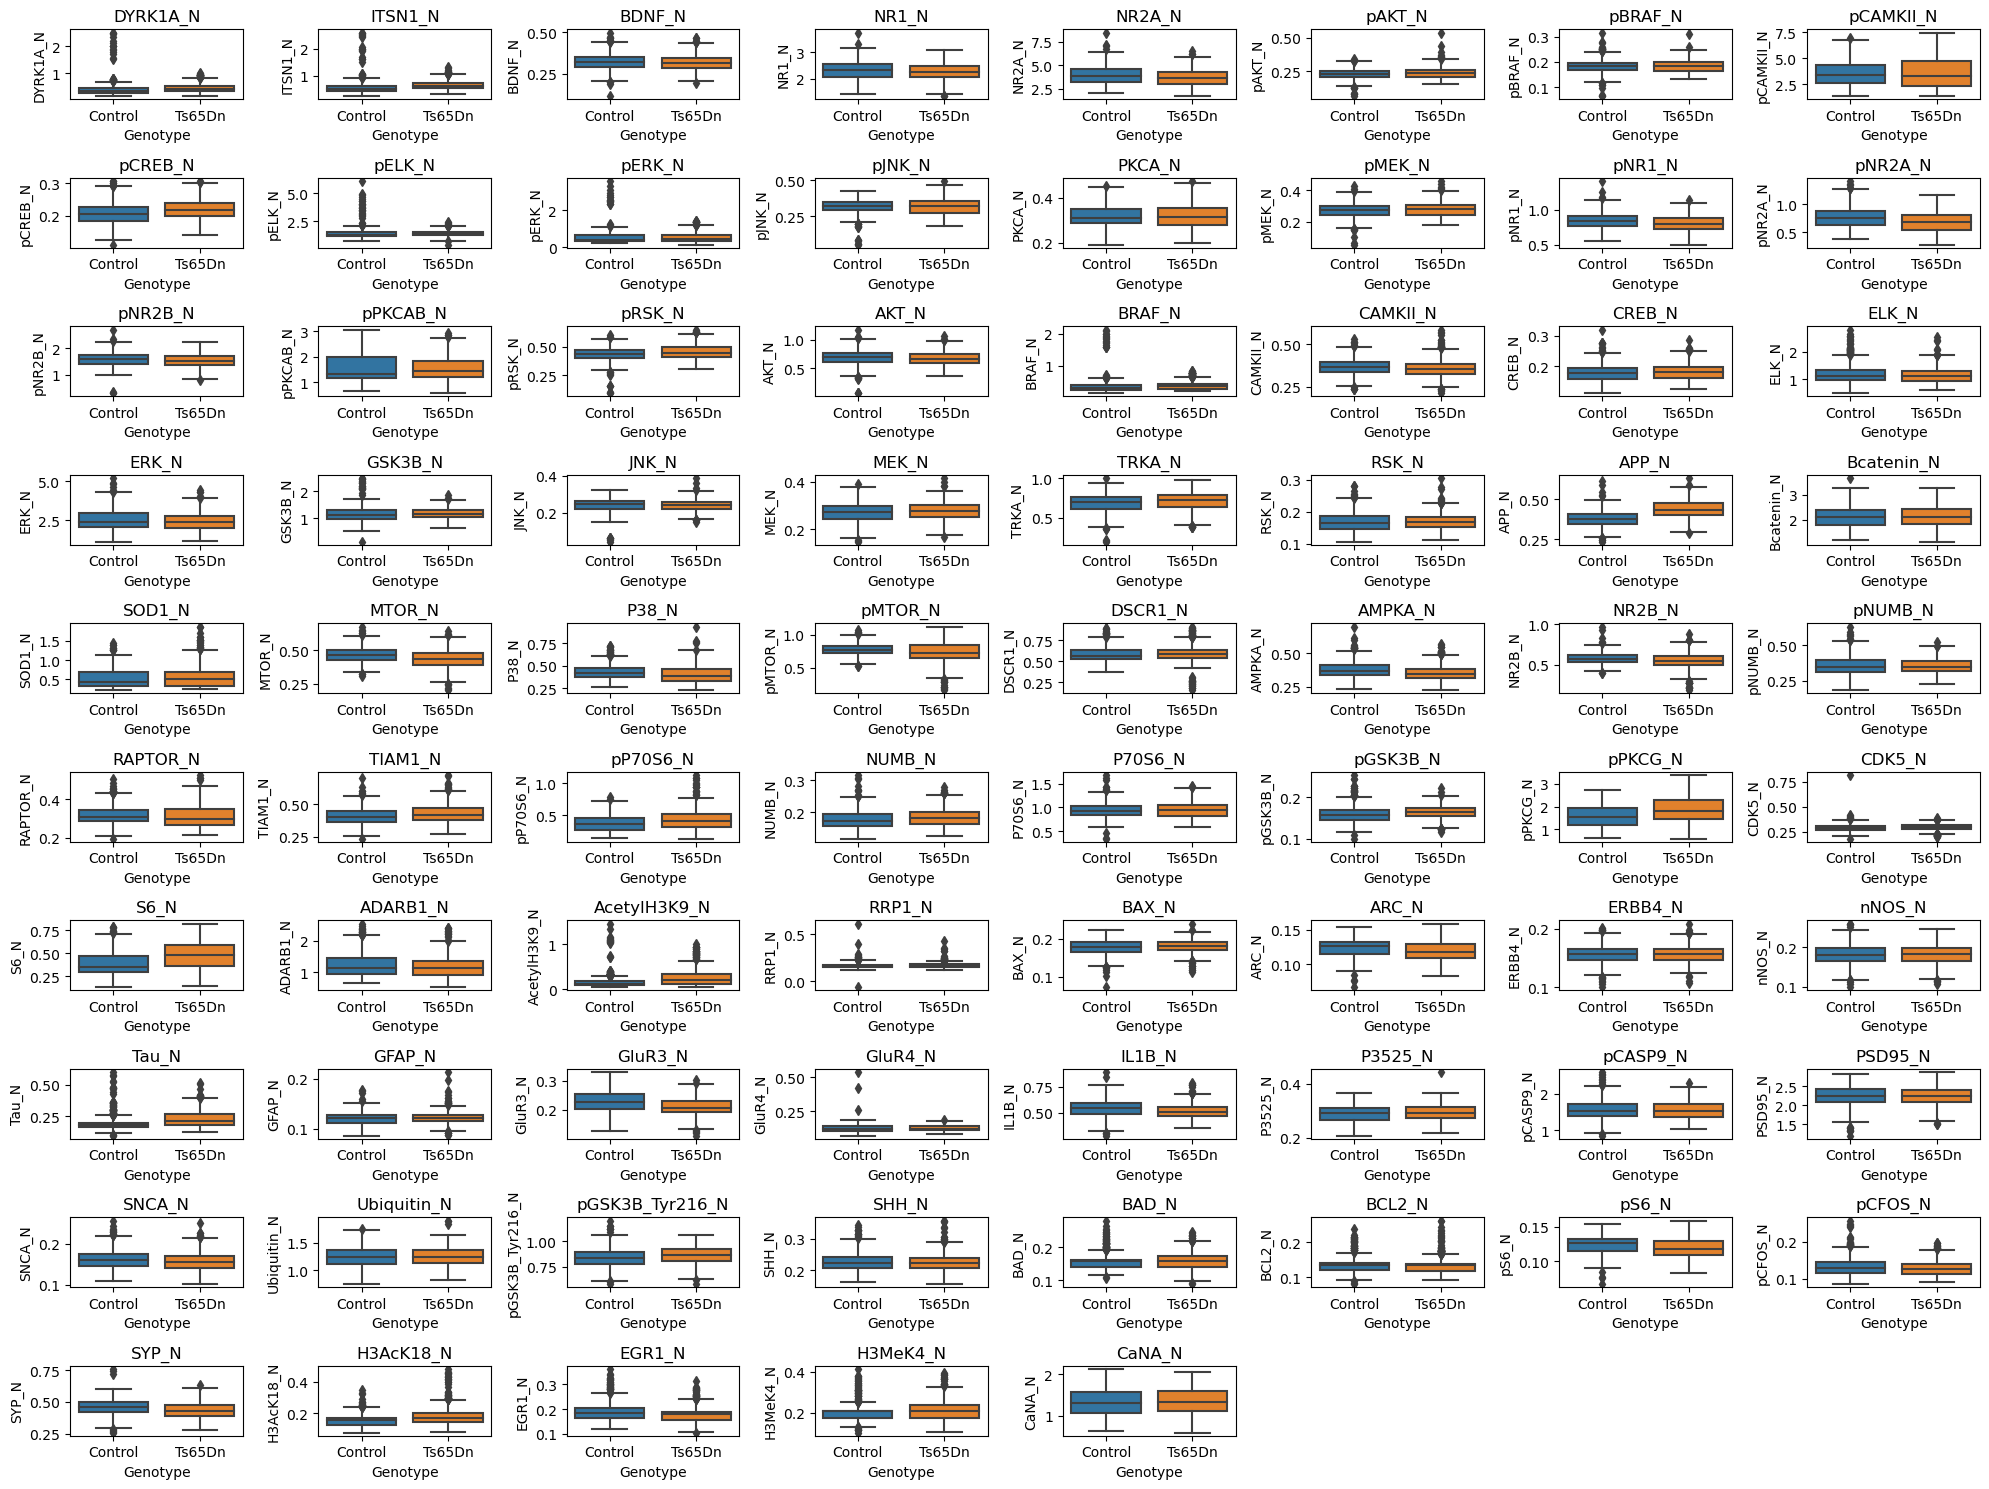

In [10]:
# Box plot of protein expression levels by genotype
plt.figure(figsize=(20, 15))
for i, column in enumerate(data.columns[1:78], 1):
    plt.subplot(10, 8, i)
    sns.boxplot(x='Genotype', y=column, data=data)
    plt.title(column)
plt.tight_layout()
plt.show()

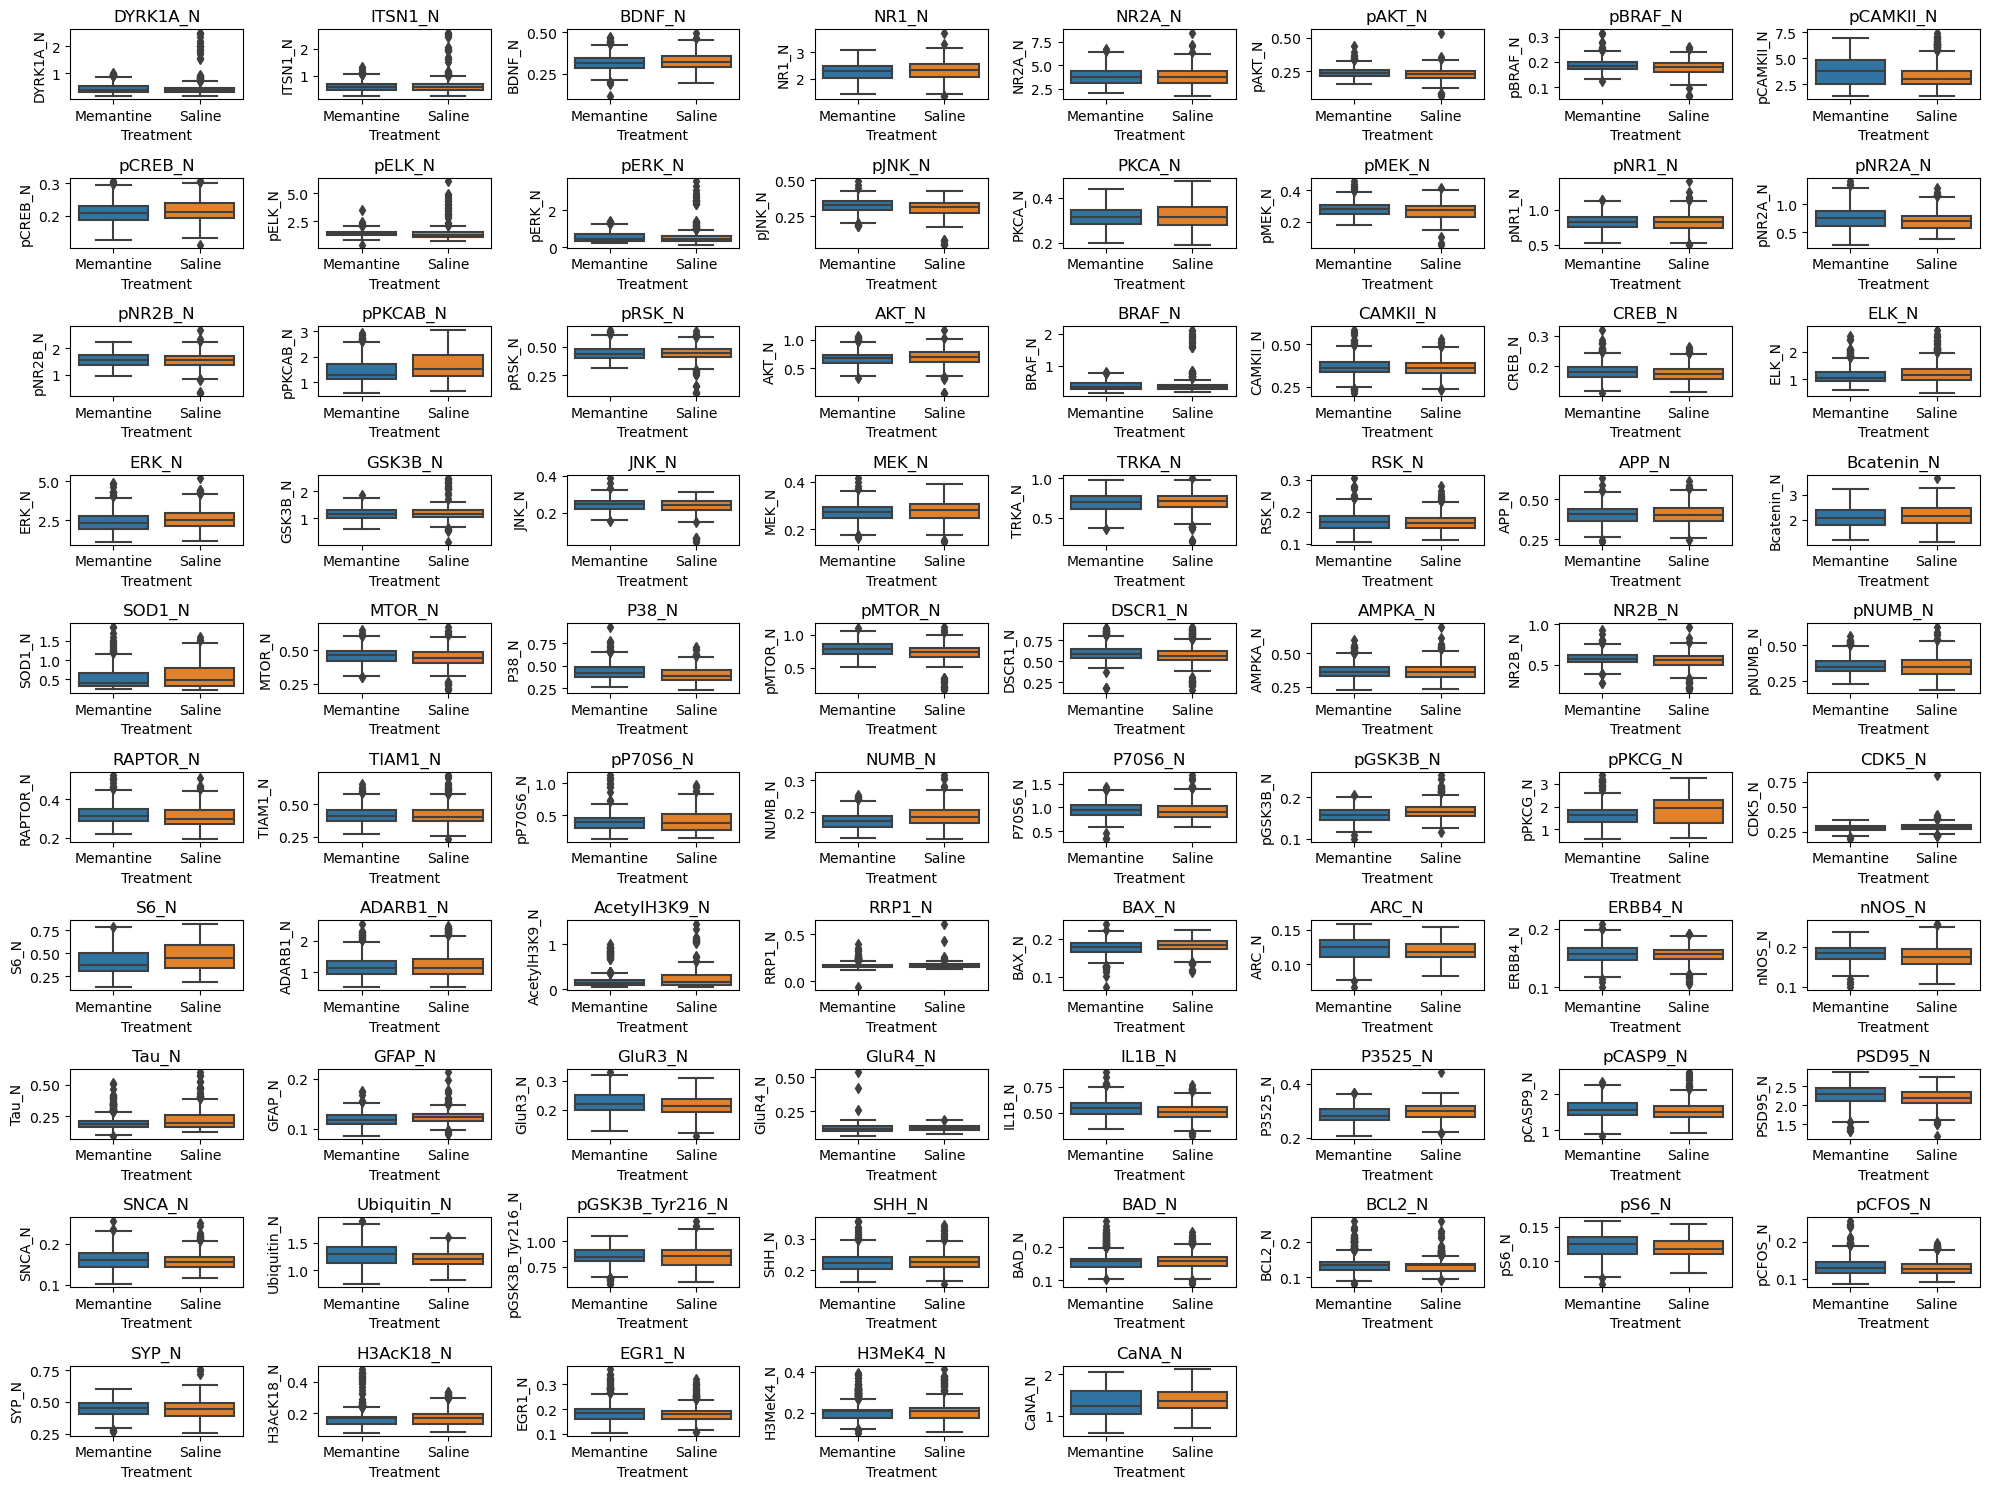

In [11]:
# Box plot of protein expression levels by treatment
plt.figure(figsize=(20, 15))
for i, column in enumerate(data.columns[1:78], 1):
    plt.subplot(10, 8, i)
    sns.boxplot(x='Treatment', y=column, data=data)
    plt.title(column)
plt.tight_layout()
plt.show()

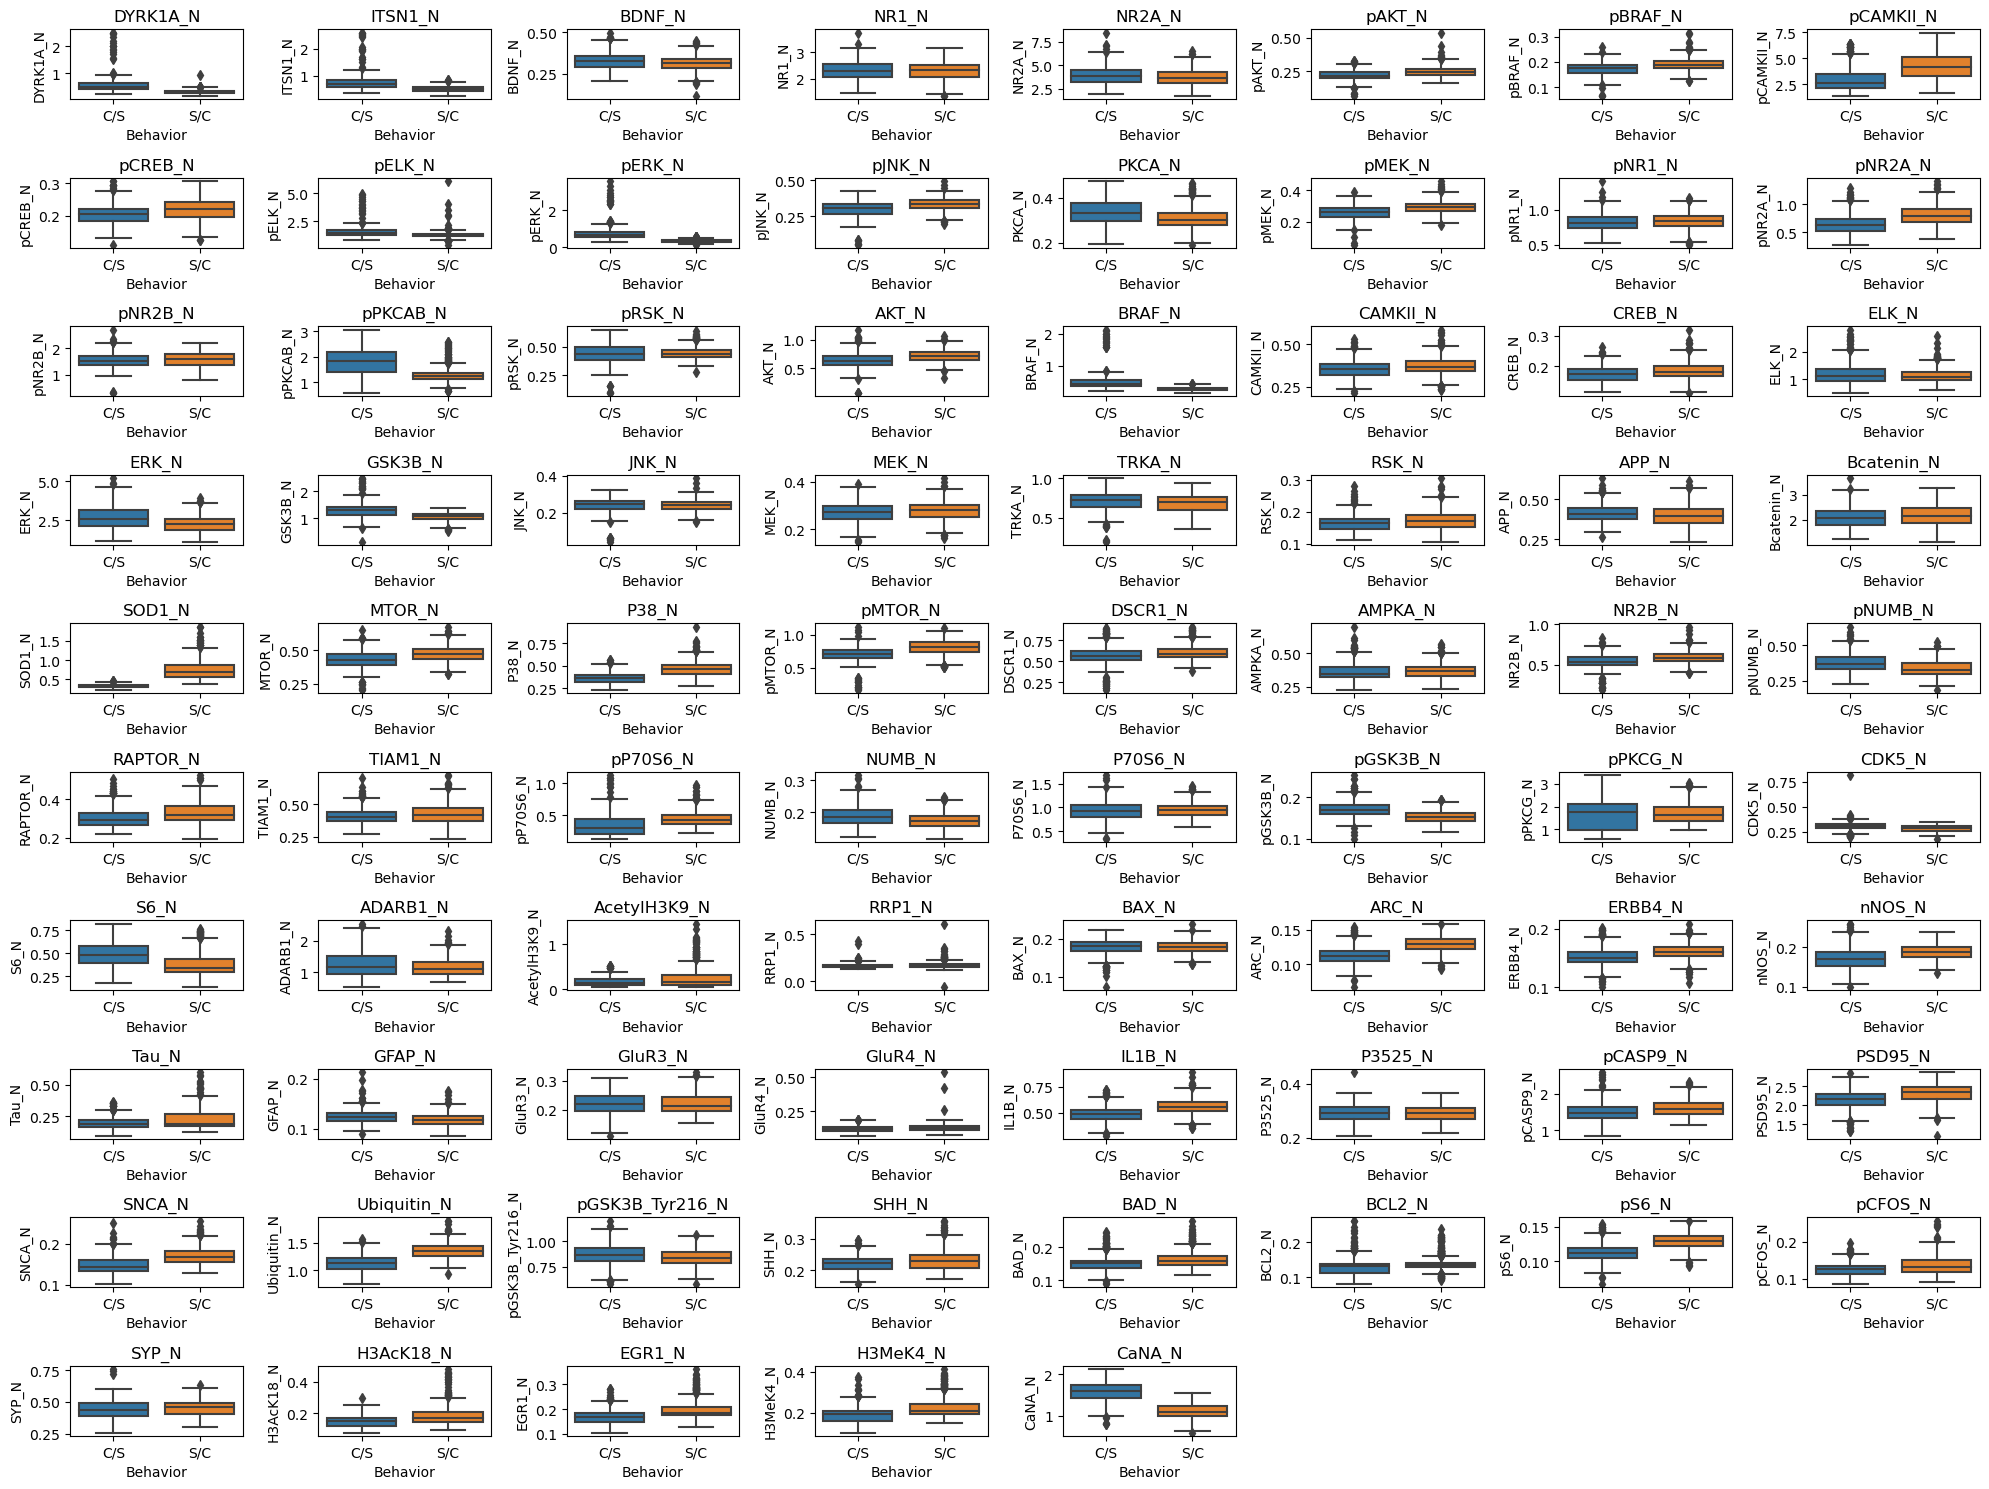

In [12]:
# Box plot of protein expression levels by behavior
plt.figure(figsize=(20, 15))
for i, column in enumerate(data.columns[1:78], 1):
    plt.subplot(10, 8, i)
    sns.boxplot(x='Behavior', y=column, data=data)
    plt.title(column)
plt.tight_layout()
plt.show()

In [13]:
# Separate features and target variable
X = data.drop(columns=['MouseID', 'Genotype', 'Treatment', 'Behavior', 'class'])
y = data['class']

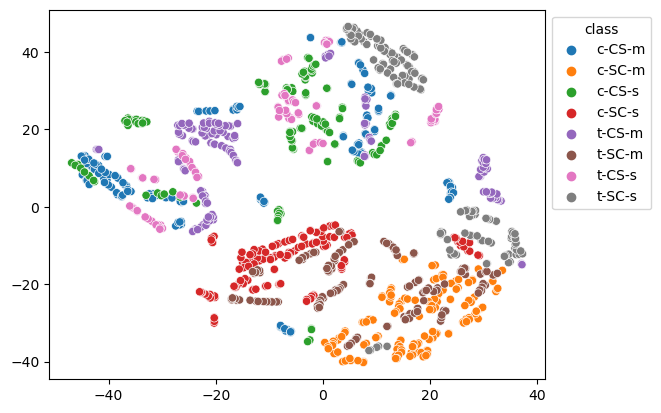

In [14]:
# Data visualization
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=0).fit_transform(X)
ax = sns.scatterplot(x=tsne[:, 0], y=tsne[:, 1], hue=y)
sns.move_legend(ax, 'upper left', bbox_to_anchor=(1, 1))

**FEATURE SELECTION**

In [15]:
from sklearn.ensemble import RandomForestClassifier

# Train a Random Forest to get feature importances
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X, y)

# Get feature importances
importances = rf.feature_importances_
feature_importances = pd.DataFrame({'Feature': X.columns, 'Importance': importances})
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

# Display top 10 important features
print(feature_importances.head(10))

        Feature  Importance
32       SOD1_N    0.068097
10       pERK_N    0.037845
46      pPKCG_N    0.037715
30        APP_N    0.031129
76       CaNA_N    0.030987
7     pCAMKII_N    0.028349
65  Ubiquitin_N    0.028067
53        ARC_N    0.026946
0      DYRK1A_N    0.025282
1       ITSN1_N    0.023739


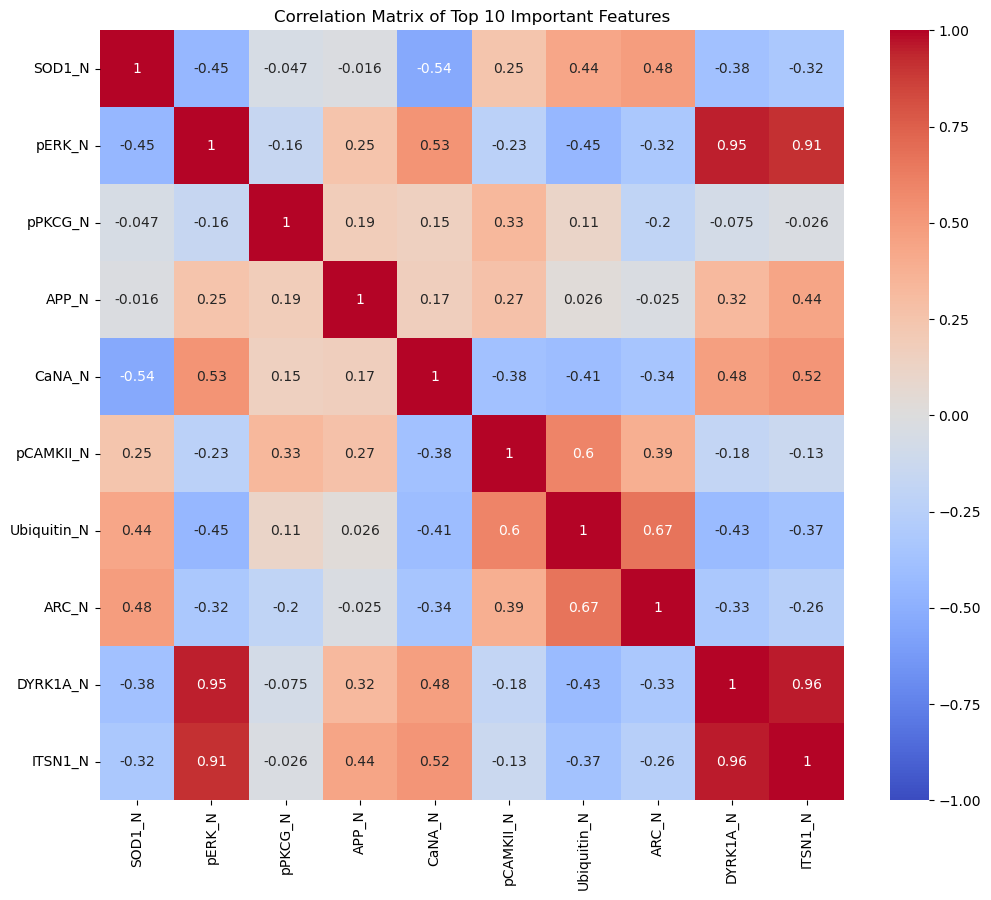

In [16]:
# Pairwise correlation of top 10 important features
top_10_features = feature_importances.head(10)['Feature'].values
corr_matrix_top_10 = data[top_10_features].corr()
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix_top_10, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix of Top 10 Important Features')
plt.show()

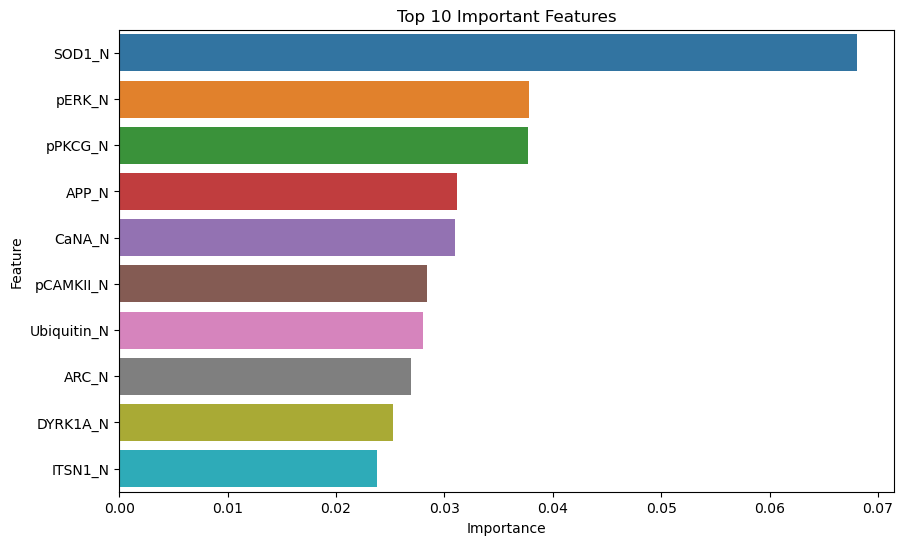

In [17]:
# Plot feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importances.head(10))
plt.title('Top 10 Important Features')
plt.show()

**MODEL TRAINING AND EVALUATION**

In [18]:
from sklearn.model_selection import train_test_split

# Separate features and target variable
X = data.drop(columns=['MouseID', 'Genotype', 'Treatment', 'Behavior', 'class'])
y = data['class']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [19]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()

y_train=label_encoder.fit_transform(y_train)
y_test=label_encoder.transform(y_test)

In [20]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
import pandas as pd
import numpy as np
import time
# Import GaussianNB
from sklearn.naive_bayes import GaussianNB
def fit_classifiers(X_train, X_test, y_train, y_test):
    # Dictionary of classifiers
    classifiers = {
        'Logistic Regression': LogisticRegression(max_iter=1000),
        'SVC': SVC(),
        'Decision Tree': DecisionTreeClassifier(),
        'Random Forest': RandomForestClassifier(),
        'Gradient Boosting': GradientBoostingClassifier(),
        'AdaBoost': AdaBoostClassifier(),
        'K-Nearest Neighbors': KNeighborsClassifier(),
        'Neural Network': MLPClassifier(max_iter=1000),
        'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
        'LightGBM': LGBMClassifier(),
        'Naive Bayes Classifier':GaussianNB()
    }

    # Lists to store results
    train_accuracy,test_accuracy, precision, recall, f1, time_taken, index_list = [], [], [], [], [], [], []

    # Loop through models
    for name, model in classifiers.items():
        print(name)
        start_time = time.time()
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        y_train_pred = model.predict(X_train)
        end_time = time.time()

        index_list.append(name)
        test_accuracy.append(accuracy_score(y_test, y_pred))
        train_accuracy.append(accuracy_score(y_train, y_train_pred))
        precision.append(precision_score(y_test, y_pred, average='weighted'))
        recall.append(recall_score(y_test, y_pred, average='weighted'))
        f1.append(f1_score(y_test, y_pred, average='weighted'))
        time_taken.append(end_time - start_time)

    # Create DataFrame of results
    results_df = pd.DataFrame({
        'Train Accuracy': train_accuracy,
        'Test Accuracy': test_accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1,
        'Time Taken': time_taken
    }, index=index_list)

    results_df.index.name = 'Models'
    results_sorted = results_df.sort_values(by='Test Accuracy', ascending=False)
    print(f'Total time taken: {sum(time_taken)} seconds')

    return results_sorted, results_df

In [21]:
results_sorted, results_df=fit_classifiers(X_train, X_test, y_train, y_test)

Logistic Regression
SVC
Decision Tree
Random Forest
Gradient Boosting
AdaBoost
K-Nearest Neighbors
Neural Network
XGBoost
LightGBM
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000754 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 19481
[LightGBM] [Info] Number of data points in the train set: 756, number of used features: 77
[LightGBM] [Info] Start training from score -1.993312
[LightGBM] [Info] Start training from score -2.173694
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -2.117182
[LightGBM] [Info] Start training from score -1.983650
[LightGBM] [Info] Start training from score -2.351375
[LightGBM] [Info] Start training from score -2.053330
[LightGBM] [Info] Start training from score -2.074164
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

In [22]:
# Model performence result
results_sorted

,Train Accuracy,Test Accuracy,Precision,Recall,F1 Score,Time Taken
Models,,,,,,
Neural Network,1.000000,0.996914,0.996978,0.996914,0.996914,4.585163
Random Forest,1.000000,0.978395,0.981460,0.978395,0.978285,0.439611
LightGBM,1.000000,0.978395,0.979039,0.978395,0.978393,1.841432
XGBoost,1.000000,0.966049,0.966907,0.966049,0.965830,1.361244
Gradient Boosting,1.000000,0.962963,0.963383,0.962963,0.962240,12.307277
K-Nearest Neighbors,0.972222,0.919753,0.925075,0.919753,0.918818,0.039883
Logistic Regression,0.920635,0.901235,0.903235,0.901235,0.899032,0.317824
Decision Tree,1.000000,0.873457,0.874638,0.873457,0.873693,0.043143
Naive Bayes Classifier,0.797619,0.762346,0.786204,0.762346,0.756700,0.010673


In [28]:
def model_performance(sub, results_sorted):
    plt.figure(figsize=(8, 3))

    # Use a colorful palette
    palette = sns.color_palette("viridis", len(results_sorted))

    ax = sns.barplot(data=results_sorted, y=results_sorted.index, x=sub, palette=palette)

    for container in ax.containers:
        ax.bar_label(container, fmt='%.2f')

    plt.title(f'{sub} for Different Models')
    plt.xticks(rotation=45)
    plt.show()


In [29]:
model_performance('Accuracy',results_sorted)

ValueError: Could not interpret input 'Accuracy'

<Figure size 800x300 with 0 Axes>